# TP Coding a GAN in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [34]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


## 1/ Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [35]:

# create a random seed for reproducible results
random_seed = 1
torch.manual_seed(random_seed)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)



In [36]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## 2/ GAN parameters

In [37]:

## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## 3/ Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [75]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(self.z_dim,self.h_dim_1) # FILL IN HERE
    self.fc2 = nn.Linear(self.h_dim_1, self.h_dim_2) # FILL IN HERE
    self.fc3 = nn.Linear(self.h_dim_2,self.n_pixels) # FILL IN HERE
  def forward(self, z):
    y = F.leaky_relu(self.fc1(z), 0.2)
    y = F.leaky_relu(self.fc2(y), 0.2)
    y = F.tanh(self.fc3(y)).view((-1,1,28,28)) # FILL IN HERE

    return(y)


In [76]:

class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear( self.n_pixels, h_dim_2)
    self.fc2 = nn.Linear(h_dim_2, h_dim_1)
    self.fc3 = nn.Linear(h_dim_1, 1)

  def forward(self, x):
    y = F.leaky_relu(self.fc1(x.view(-1, self.n_pixels)), 0.2)
    y = F.leaky_relu(self.fc2(y), 0.2)
    y =  F.sigmoid(self.fc3(y)) # FILL IN HERE
    return y




Create generator and discriminator 

In [77]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2,  n_rows, n_cols, n_channels) # FILL IN HERE
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_2, h_dim_1, z_dim, n_rows, n_cols, n_channels) # FILL IN HERE
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


## 4/ Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [78]:
# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = nn.BCELoss() # FILL IN HERE

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  loss_gen = torch.log( 1 - d_gen_data).mean()  # FILL IN CODE
  return loss_gen	

### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [82]:

def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device='cpu') #np.random.normal(0, 1, (r * c, z_dim))
  
  gen_imgs = np.transpose( generator(z_random).cpu().detach().numpy() , (0,2,3,1))

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0) 
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## 5/ Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```np.random.normal``` to create a batch of random latent codes, and ```np.random.randint``` to create a batch of random images.

You can then train the discriminator and the generator using the ```train_on_batch``` function.

We do not worry here about looping over the whole database : just create a random batch at each iteration.

Starting Training
[0/400][0/16] 	Loss_D: 0.9427	Loss_G: -0.7557	D(x): 0.8973	D(G(z)): 0.5657


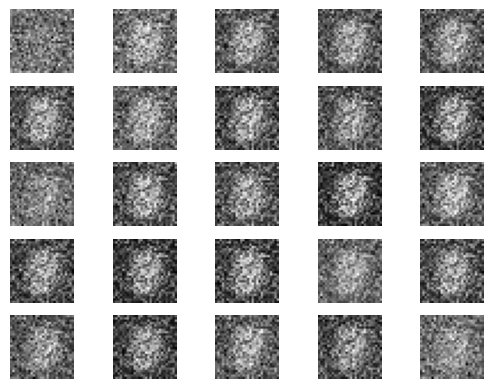

[1/400][0/16] 	Loss_D: 1.1054	Loss_G: -0.7219	D(x): 0.7688	D(G(z)): 0.5688
[2/400][0/16] 	Loss_D: 1.2917	Loss_G: -0.7387	D(x): 0.6772	D(G(z)): 0.5928
[3/400][0/16] 	Loss_D: 1.1239	Loss_G: -0.5082	D(x): 0.7139	D(G(z)): 0.5431
[4/400][0/16] 	Loss_D: 0.6113	Loss_G: -0.2652	D(x): 0.8159	D(G(z)): 0.3321
[5/400][0/16] 	Loss_D: 3.9833	Loss_G: -2.2274	D(x): 0.5356	D(G(z)): 0.9623
[6/400][0/16] 	Loss_D: 0.0951	Loss_G: -0.0460	D(x): 0.9648	D(G(z)): 0.0574
[7/400][0/16] 	Loss_D: 0.0266	Loss_G: -0.0137	D(x): 0.9889	D(G(z)): 0.0152
[8/400][0/16] 	Loss_D: 0.0159	Loss_G: -0.0084	D(x): 0.9933	D(G(z)): 0.0092
[9/400][0/16] 	Loss_D: 0.0117	Loss_G: -0.0065	D(x): 0.9954	D(G(z)): 0.0071
[10/400][0/16] 	Loss_D: 0.0123	Loss_G: -0.0067	D(x): 0.9950	D(G(z)): 0.0073
[11/400][0/16] 	Loss_D: 0.0187	Loss_G: -0.0098	D(x): 0.9936	D(G(z)): 0.0122
[12/400][0/16] 	Loss_D: 5.5991	Loss_G: -2.1721	D(x): 0.9466	D(G(z)): 0.9957
[13/400][0/16] 	Loss_D: 0.0498	Loss_G: -0.0203	D(x): 0.9733	D(G(z)): 0.0224
[14/400][0/16] 	Loss_

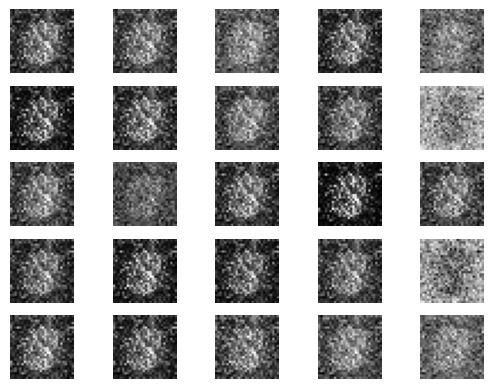

[26/400][0/16] 	Loss_D: 0.0051	Loss_G: -0.0030	D(x): 0.9981	D(G(z)): 0.0032
[27/400][0/16] 	Loss_D: 0.0068	Loss_G: -0.0037	D(x): 0.9973	D(G(z)): 0.0041
[28/400][0/16] 	Loss_D: 0.0240	Loss_G: -0.0110	D(x): 0.9886	D(G(z)): 0.0123
[29/400][0/16] 	Loss_D: 0.2638	Loss_G: -0.1508	D(x): 0.8532	D(G(z)): 0.0960
[30/400][0/16] 	Loss_D: 1.7052	Loss_G: -0.1388	D(x): 0.7787	D(G(z)): 0.7657
[31/400][0/16] 	Loss_D: 0.4426	Loss_G: -0.1129	D(x): 0.7990	D(G(z)): 0.1932
[32/400][0/16] 	Loss_D: 1.2679	Loss_G: -0.3820	D(x): 0.6094	D(G(z)): 0.5358
[33/400][0/16] 	Loss_D: 0.4039	Loss_G: -0.1710	D(x): 0.8272	D(G(z)): 0.1876
[34/400][0/16] 	Loss_D: 1.4529	Loss_G: -0.3870	D(x): 0.5989	D(G(z)): 0.5956
[35/400][0/16] 	Loss_D: 0.1159	Loss_G: -0.0411	D(x): 0.9544	D(G(z)): 0.0663
[36/400][0/16] 	Loss_D: 2.3388	Loss_G: -0.4750	D(x): 0.8492	D(G(z)): 0.8851
[37/400][0/16] 	Loss_D: 0.2717	Loss_G: -0.0768	D(x): 0.9111	D(G(z)): 0.1601
[38/400][0/16] 	Loss_D: 3.8552	Loss_G: -1.6535	D(x): 0.9239	D(G(z)): 0.9762
[39/400][0/1

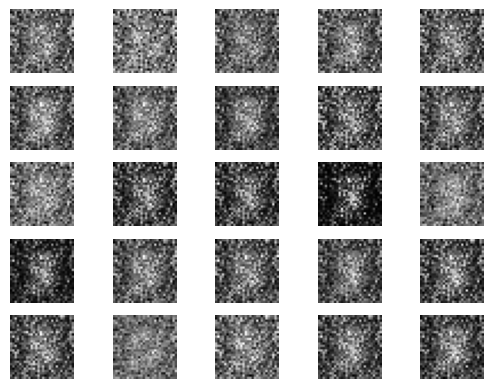

[51/400][0/16] 	Loss_D: 0.2100	Loss_G: -0.0740	D(x): 0.9480	D(G(z)): 0.1425
[52/400][0/16] 	Loss_D: 0.4930	Loss_G: -0.1503	D(x): 0.9839	D(G(z)): 0.3594
[53/400][0/16] 	Loss_D: 0.0192	Loss_G: -0.0149	D(x): 0.9999	D(G(z)): 0.0189
[54/400][0/16] 	Loss_D: 0.0655	Loss_G: -0.0339	D(x): 1.0000	D(G(z)): 0.0618
[55/400][0/16] 	Loss_D: 0.3800	Loss_G: -0.0651	D(x): 0.9384	D(G(z)): 0.2101
[56/400][0/16] 	Loss_D: 0.4546	Loss_G: -0.1363	D(x): 0.8334	D(G(z)): 0.1555
[57/400][0/16] 	Loss_D: 0.2131	Loss_G: -0.1309	D(x): 0.8950	D(G(z)): 0.0820
[58/400][0/16] 	Loss_D: 1.0087	Loss_G: -0.4971	D(x): 0.6274	D(G(z)): 0.3135
[59/400][0/16] 	Loss_D: 0.1445	Loss_G: -0.0432	D(x): 0.9572	D(G(z)): 0.0943
[60/400][0/16] 	Loss_D: 1.1331	Loss_G: -0.0040	D(x): 0.9869	D(G(z)): 0.6646
[61/400][0/16] 	Loss_D: 0.2090	Loss_G: -0.0863	D(x): 0.9164	D(G(z)): 0.1050
[62/400][0/16] 	Loss_D: 0.3035	Loss_G: -0.0938	D(x): 0.8665	D(G(z)): 0.1243
[63/400][0/16] 	Loss_D: 0.2364	Loss_G: -0.0820	D(x): 0.8761	D(G(z)): 0.0594
[64/400][0/1

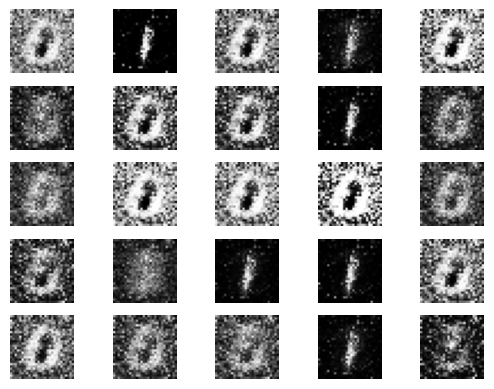

[76/400][0/16] 	Loss_D: 0.1960	Loss_G: -0.1460	D(x): 0.8824	D(G(z)): 0.0236
[77/400][0/16] 	Loss_D: 0.1448	Loss_G: -0.0226	D(x): 0.9905	D(G(z)): 0.1253
[78/400][0/16] 	Loss_D: 0.0962	Loss_G: -0.0451	D(x): 0.9541	D(G(z)): 0.0397
[79/400][0/16] 	Loss_D: 0.0832	Loss_G: -0.0261	D(x): 0.9605	D(G(z)): 0.0384
[80/400][0/16] 	Loss_D: 0.0938	Loss_G: -0.0486	D(x): 0.9705	D(G(z)): 0.0562
[81/400][0/16] 	Loss_D: 0.1375	Loss_G: -0.0088	D(x): 0.9894	D(G(z)): 0.1167
[82/400][0/16] 	Loss_D: 0.1113	Loss_G: -0.0776	D(x): 0.9396	D(G(z)): 0.0279
[83/400][0/16] 	Loss_D: 0.1381	Loss_G: -0.0808	D(x): 0.9895	D(G(z)): 0.1162
[84/400][0/16] 	Loss_D: 0.1101	Loss_G: -0.0585	D(x): 0.9577	D(G(z)): 0.0524
[85/400][0/16] 	Loss_D: 1.3967	Loss_G: -0.0032	D(x): 0.9915	D(G(z)): 0.6212
[86/400][0/16] 	Loss_D: 0.1022	Loss_G: -0.0310	D(x): 0.9446	D(G(z)): 0.0321
[87/400][0/16] 	Loss_D: 0.1339	Loss_G: -0.0311	D(x): 0.9724	D(G(z)): 0.0838
[88/400][0/16] 	Loss_D: 0.1770	Loss_G: -0.0237	D(x): 0.9063	D(G(z)): 0.0361
[89/400][0/1

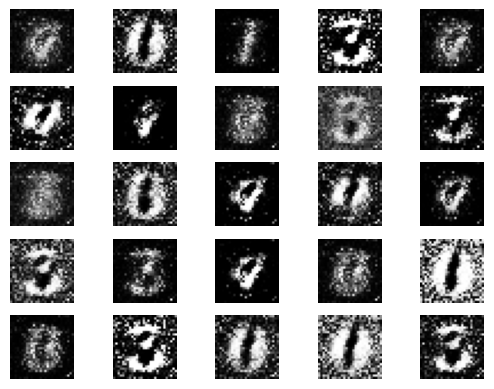

[101/400][0/16] 	Loss_D: 0.1047	Loss_G: -0.0383	D(x): 0.9518	D(G(z)): 0.0486
[102/400][0/16] 	Loss_D: 0.1477	Loss_G: -0.0170	D(x): 0.9725	D(G(z)): 0.1092
[103/400][0/16] 	Loss_D: 0.0603	Loss_G: -0.0259	D(x): 0.9744	D(G(z)): 0.0326
[104/400][0/16] 	Loss_D: 0.0730	Loss_G: -0.0337	D(x): 0.9648	D(G(z)): 0.0339
[105/400][0/16] 	Loss_D: 0.0691	Loss_G: -0.0129	D(x): 0.9624	D(G(z)): 0.0251
[106/400][0/16] 	Loss_D: 0.1001	Loss_G: -0.0476	D(x): 0.9380	D(G(z)): 0.0249
[107/400][0/16] 	Loss_D: 0.3715	Loss_G: -0.4083	D(x): 0.8337	D(G(z)): 0.0799
[108/400][0/16] 	Loss_D: 0.2705	Loss_G: -0.0341	D(x): 0.9685	D(G(z)): 0.1962
[109/400][0/16] 	Loss_D: 0.1713	Loss_G: -0.0821	D(x): 0.9165	D(G(z)): 0.0605
[110/400][0/16] 	Loss_D: 0.1131	Loss_G: -0.0335	D(x): 0.9227	D(G(z)): 0.0184
[111/400][0/16] 	Loss_D: 0.0744	Loss_G: -0.0222	D(x): 0.9617	D(G(z)): 0.0316
[112/400][0/16] 	Loss_D: 0.1758	Loss_G: -0.0137	D(x): 0.9876	D(G(z)): 0.1461
[113/400][0/16] 	Loss_D: 0.0816	Loss_G: -0.0254	D(x): 0.9672	D(G(z)): 0.0394

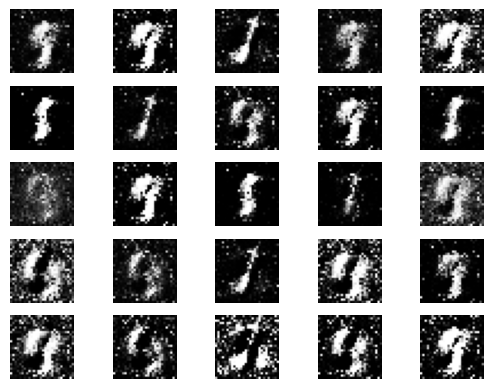

[126/400][0/16] 	Loss_D: 0.0733	Loss_G: -0.0323	D(x): 0.9597	D(G(z)): 0.0239
[127/400][0/16] 	Loss_D: 0.2171	Loss_G: -0.0290	D(x): 0.9966	D(G(z)): 0.1629
[128/400][0/16] 	Loss_D: 0.0891	Loss_G: -0.0331	D(x): 0.9655	D(G(z)): 0.0353
[129/400][0/16] 	Loss_D: 0.1736	Loss_G: -0.1365	D(x): 0.9570	D(G(z)): 0.0991
[130/400][0/16] 	Loss_D: 0.1014	Loss_G: -0.0360	D(x): 0.9584	D(G(z)): 0.0409
[131/400][0/16] 	Loss_D: 0.3708	Loss_G: -0.0143	D(x): 0.9666	D(G(z)): 0.2304
[132/400][0/16] 	Loss_D: 0.0430	Loss_G: -0.0162	D(x): 0.9883	D(G(z)): 0.0299
[133/400][0/16] 	Loss_D: 0.0668	Loss_G: -0.0202	D(x): 0.9668	D(G(z)): 0.0206
[134/400][0/16] 	Loss_D: 0.2571	Loss_G: -0.0034	D(x): 0.9050	D(G(z)): 0.0024
[135/400][0/16] 	Loss_D: 0.0533	Loss_G: -0.0249	D(x): 0.9700	D(G(z)): 0.0130
[136/400][0/16] 	Loss_D: 0.0643	Loss_G: -0.0211	D(x): 0.9779	D(G(z)): 0.0363
[137/400][0/16] 	Loss_D: 0.9270	Loss_G: -0.0798	D(x): 0.6862	D(G(z)): 0.0002
[138/400][0/16] 	Loss_D: 0.1313	Loss_G: -0.0412	D(x): 0.9865	D(G(z)): 0.0995

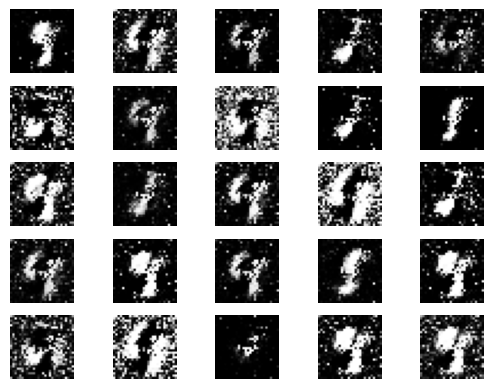

[151/400][0/16] 	Loss_D: 3.3611	Loss_G: -1.3941	D(x): 0.4369	D(G(z)): 0.0001
[152/400][0/16] 	Loss_D: 0.1256	Loss_G: -0.0362	D(x): 0.9352	D(G(z)): 0.0351
[153/400][0/16] 	Loss_D: 0.0587	Loss_G: -0.0134	D(x): 0.9679	D(G(z)): 0.0235
[154/400][0/16] 	Loss_D: 0.0257	Loss_G: -0.0112	D(x): 0.9906	D(G(z)): 0.0158
[155/400][0/16] 	Loss_D: 0.0279	Loss_G: -0.0083	D(x): 0.9829	D(G(z)): 0.0095
[156/400][0/16] 	Loss_D: 0.0281	Loss_G: -0.0084	D(x): 0.9846	D(G(z)): 0.0101
[157/400][0/16] 	Loss_D: 0.0199	Loss_G: -0.0071	D(x): 0.9893	D(G(z)): 0.0075
[158/400][0/16] 	Loss_D: 0.0092	Loss_G: -0.0033	D(x): 0.9951	D(G(z)): 0.0042
[159/400][0/16] 	Loss_D: 0.0072	Loss_G: -0.0036	D(x): 0.9974	D(G(z)): 0.0046
[160/400][0/16] 	Loss_D: 0.0186	Loss_G: -0.0053	D(x): 0.9885	D(G(z)): 0.0057
[161/400][0/16] 	Loss_D: 0.0135	Loss_G: -0.0032	D(x): 0.9904	D(G(z)): 0.0026
[162/400][0/16] 	Loss_D: 0.0096	Loss_G: -0.0047	D(x): 0.9974	D(G(z)): 0.0069
[163/400][0/16] 	Loss_D: 0.0083	Loss_G: -0.0040	D(x): 0.9965	D(G(z)): 0.0046

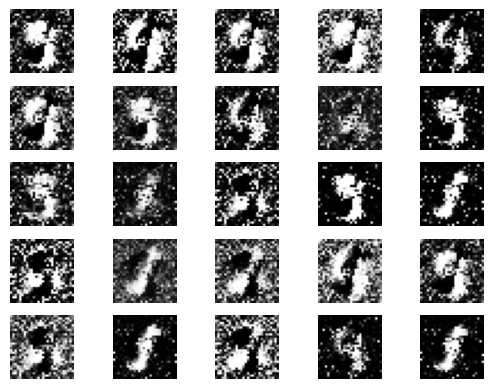

[176/400][0/16] 	Loss_D: 0.0633	Loss_G: -0.0008	D(x): 0.9972	D(G(z)): 0.0560
[177/400][0/16] 	Loss_D: 0.0129	Loss_G: -0.0021	D(x): 0.9949	D(G(z)): 0.0074
[178/400][0/16] 	Loss_D: 0.0090	Loss_G: -0.0098	D(x): 0.9968	D(G(z)): 0.0056
[179/400][0/16] 	Loss_D: 0.0424	Loss_G: -0.0198	D(x): 0.9788	D(G(z)): 0.0049
[180/400][0/16] 	Loss_D: 0.1091	Loss_G: -0.0000	D(x): 0.9969	D(G(z)): 0.0953
[181/400][0/16] 	Loss_D: 0.4960	Loss_G: -0.0080	D(x): 0.9991	D(G(z)): 0.2915
[182/400][0/16] 	Loss_D: 0.7394	Loss_G: -0.0008	D(x): 0.9872	D(G(z)): 0.4210
[183/400][0/16] 	Loss_D: 1.2364	Loss_G: -0.0026	D(x): 0.5988	D(G(z)): 0.0008
[184/400][0/16] 	Loss_D: 0.1852	Loss_G: -0.0297	D(x): 0.9150	D(G(z)): 0.0359
[185/400][0/16] 	Loss_D: 0.2492	Loss_G: -0.0037	D(x): 0.9908	D(G(z)): 0.2056
[186/400][0/16] 	Loss_D: 0.0444	Loss_G: -0.0137	D(x): 0.9801	D(G(z)): 0.0226
[187/400][0/16] 	Loss_D: 0.0532	Loss_G: -0.0309	D(x): 0.9793	D(G(z)): 0.0278
[188/400][0/16] 	Loss_D: 0.0413	Loss_G: -0.0109	D(x): 0.9830	D(G(z)): 0.0218

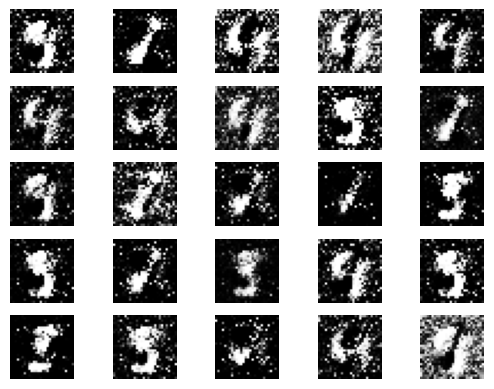

[201/400][0/16] 	Loss_D: 0.0214	Loss_G: -0.0245	D(x): 0.9979	D(G(z)): 0.0188
[202/400][0/16] 	Loss_D: 0.0110	Loss_G: -0.0037	D(x): 0.9960	D(G(z)): 0.0068
[203/400][0/16] 	Loss_D: 0.0050	Loss_G: -0.0015	D(x): 0.9972	D(G(z)): 0.0022
[204/400][0/16] 	Loss_D: 0.0057	Loss_G: -0.0029	D(x): 0.9976	D(G(z)): 0.0032
[205/400][0/16] 	Loss_D: 0.0192	Loss_G: -0.1394	D(x): 0.9998	D(G(z)): 0.0181
[206/400][0/16] 	Loss_D: 0.2157	Loss_G: -0.0506	D(x): 0.9142	D(G(z)): 0.0563
[207/400][0/16] 	Loss_D: 0.3536	Loss_G: -0.1515	D(x): 0.9019	D(G(z)): 0.0869
[208/400][0/16] 	Loss_D: 0.0339	Loss_G: -0.0084	D(x): 0.9789	D(G(z)): 0.0093
[209/400][0/16] 	Loss_D: 0.0166	Loss_G: -0.0062	D(x): 0.9928	D(G(z)): 0.0086
[210/400][0/16] 	Loss_D: 0.0508	Loss_G: -0.0142	D(x): 0.9910	D(G(z)): 0.0371
[211/400][0/16] 	Loss_D: 0.0636	Loss_G: -0.0208	D(x): 0.9557	D(G(z)): 0.0109
[212/400][0/16] 	Loss_D: 0.1007	Loss_G: -0.0185	D(x): 0.9449	D(G(z)): 0.0063
[213/400][0/16] 	Loss_D: 4.1092	Loss_G: -0.0140	D(x): 0.9982	D(G(z)): 0.9291

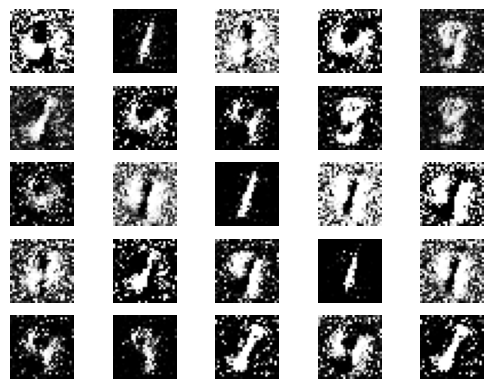

[226/400][0/16] 	Loss_D: 0.0195	Loss_G: -0.0068	D(x): 0.9862	D(G(z)): 0.0041
[227/400][0/16] 	Loss_D: 0.0265	Loss_G: -0.0000	D(x): 0.9789	D(G(z)): 0.0001
[228/400][0/16] 	Loss_D: 0.0451	Loss_G: -0.0140	D(x): 0.9822	D(G(z)): 0.0101
[229/400][0/16] 	Loss_D: 0.0672	Loss_G: -0.0263	D(x): 0.9755	D(G(z)): 0.0325
[230/400][0/16] 	Loss_D: 0.2207	Loss_G: -0.0169	D(x): 0.9024	D(G(z)): 0.0666
[231/400][0/16] 	Loss_D: 0.1156	Loss_G: -0.0226	D(x): 0.9220	D(G(z)): 0.0179
[232/400][0/16] 	Loss_D: 0.0517	Loss_G: -0.0194	D(x): 0.9728	D(G(z)): 0.0208
[233/400][0/16] 	Loss_D: 0.0379	Loss_G: -0.0111	D(x): 0.9870	D(G(z)): 0.0234
[234/400][0/16] 	Loss_D: 0.0651	Loss_G: -0.0267	D(x): 0.9737	D(G(z)): 0.0326
[235/400][0/16] 	Loss_D: 0.0934	Loss_G: -0.0040	D(x): 0.9848	D(G(z)): 0.0709
[236/400][0/16] 	Loss_D: 0.0628	Loss_G: -0.0138	D(x): 0.9519	D(G(z)): 0.0039
[237/400][0/16] 	Loss_D: 0.0760	Loss_G: -0.0026	D(x): 0.9972	D(G(z)): 0.0673
[238/400][0/16] 	Loss_D: 0.0173	Loss_G: -0.0045	D(x): 0.9893	D(G(z)): 0.0061

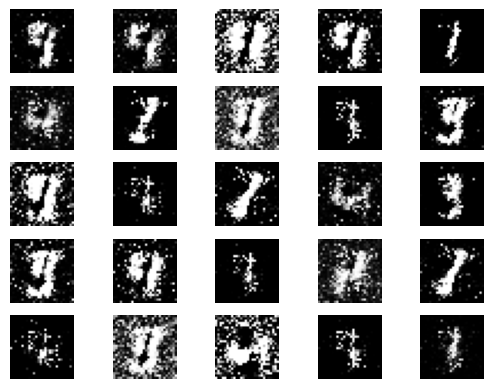

[251/400][0/16] 	Loss_D: 1.8929	Loss_G: -0.0000	D(x): 0.9993	D(G(z)): 0.7951
[252/400][0/16] 	Loss_D: 0.0341	Loss_G: -0.0190	D(x): 0.9850	D(G(z)): 0.0174
[253/400][0/16] 	Loss_D: 0.1207	Loss_G: -0.0203	D(x): 0.9819	D(G(z)): 0.0848
[254/400][0/16] 	Loss_D: 0.1691	Loss_G: -0.0309	D(x): 0.9398	D(G(z)): 0.0718
[255/400][0/16] 	Loss_D: 0.0512	Loss_G: -0.0226	D(x): 0.9725	D(G(z)): 0.0194
[256/400][0/16] 	Loss_D: 0.0545	Loss_G: -0.0147	D(x): 0.9684	D(G(z)): 0.0111
[257/400][0/16] 	Loss_D: 0.0402	Loss_G: -0.0114	D(x): 0.9879	D(G(z)): 0.0249
[258/400][0/16] 	Loss_D: 0.0572	Loss_G: -0.0120	D(x): 0.9943	D(G(z)): 0.0480
[259/400][0/16] 	Loss_D: 0.0767	Loss_G: -0.0422	D(x): 0.9780	D(G(z)): 0.0211
[260/400][0/16] 	Loss_D: 0.1309	Loss_G: -0.0258	D(x): 0.9486	D(G(z)): 0.0089
[261/400][0/16] 	Loss_D: 0.0792	Loss_G: -0.0132	D(x): 0.9613	D(G(z)): 0.0073
[262/400][0/16] 	Loss_D: 0.0231	Loss_G: -0.0018	D(x): 0.9847	D(G(z)): 0.0035
[263/400][0/16] 	Loss_D: 0.4804	Loss_G: -0.0016	D(x): 0.9698	D(G(z)): 0.2636

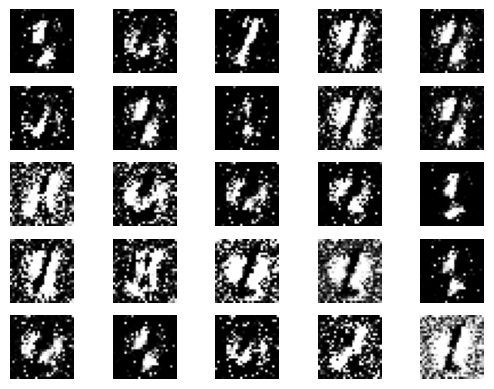

[276/400][0/16] 	Loss_D: 0.1254	Loss_G: -0.0075	D(x): 0.9497	D(G(z)): 0.0068
[277/400][0/16] 	Loss_D: 0.0263	Loss_G: -0.0102	D(x): 0.9886	D(G(z)): 0.0140
[278/400][0/16] 	Loss_D: 0.0400	Loss_G: -0.0088	D(x): 0.9866	D(G(z)): 0.0249
[279/400][0/16] 	Loss_D: 0.0993	Loss_G: -0.0022	D(x): 0.9481	D(G(z)): 0.0025
[280/400][0/16] 	Loss_D: 1.0341	Loss_G: -0.1412	D(x): 0.7716	D(G(z)): 0.0109
[281/400][0/16] 	Loss_D: 0.3068	Loss_G: -0.0028	D(x): 0.9518	D(G(z)): 0.1782
[282/400][0/16] 	Loss_D: 1.3574	Loss_G: -0.0032	D(x): 0.6065	D(G(z)): 0.0001
[283/400][0/16] 	Loss_D: 0.1452	Loss_G: -0.0541	D(x): 0.9427	D(G(z)): 0.0524
[284/400][0/16] 	Loss_D: 0.1202	Loss_G: -0.0193	D(x): 0.9760	D(G(z)): 0.0843
[285/400][0/16] 	Loss_D: 0.1076	Loss_G: -0.0113	D(x): 0.9795	D(G(z)): 0.0746
[286/400][0/16] 	Loss_D: 0.0320	Loss_G: -0.0200	D(x): 0.9914	D(G(z)): 0.0218
[287/400][0/16] 	Loss_D: 0.1046	Loss_G: -0.0198	D(x): 0.9739	D(G(z)): 0.0693
[288/400][0/16] 	Loss_D: 0.2142	Loss_G: -0.0039	D(x): 0.9696	D(G(z)): 0.1472

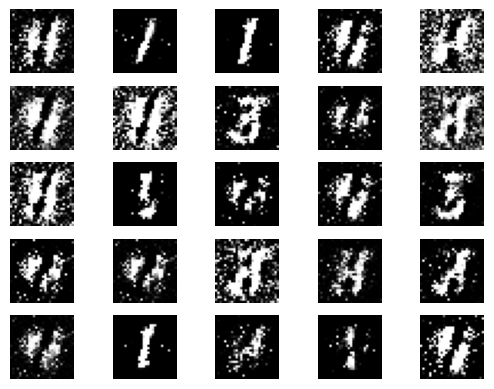

[301/400][0/16] 	Loss_D: 4.0659	Loss_G: -0.0267	D(x): 0.4098	D(G(z)): 0.0000
[302/400][0/16] 	Loss_D: 0.1478	Loss_G: -0.0377	D(x): 0.9301	D(G(z)): 0.0389
[303/400][0/16] 	Loss_D: 0.1948	Loss_G: -0.0307	D(x): 0.9671	D(G(z)): 0.1226
[304/400][0/16] 	Loss_D: 0.1997	Loss_G: -0.1326	D(x): 0.8786	D(G(z)): 0.0134
[305/400][0/16] 	Loss_D: 0.1290	Loss_G: -0.0352	D(x): 0.9606	D(G(z)): 0.0561
[306/400][0/16] 	Loss_D: 0.1092	Loss_G: -0.0589	D(x): 0.9398	D(G(z)): 0.0160
[307/400][0/16] 	Loss_D: 0.0449	Loss_G: -0.0112	D(x): 0.9720	D(G(z)): 0.0125
[308/400][0/16] 	Loss_D: 0.1644	Loss_G: -0.0076	D(x): 0.9158	D(G(z)): 0.0021
[309/400][0/16] 	Loss_D: 0.2075	Loss_G: -0.0160	D(x): 0.9006	D(G(z)): 0.0203
[310/400][0/16] 	Loss_D: 0.1629	Loss_G: -0.0311	D(x): 0.9680	D(G(z)): 0.0918
[311/400][0/16] 	Loss_D: 0.1284	Loss_G: -0.0416	D(x): 0.9608	D(G(z)): 0.0730
[312/400][0/16] 	Loss_D: 0.1156	Loss_G: -0.0404	D(x): 0.9619	D(G(z)): 0.0505
[313/400][0/16] 	Loss_D: 0.0497	Loss_G: -0.0130	D(x): 0.9731	D(G(z)): 0.0198

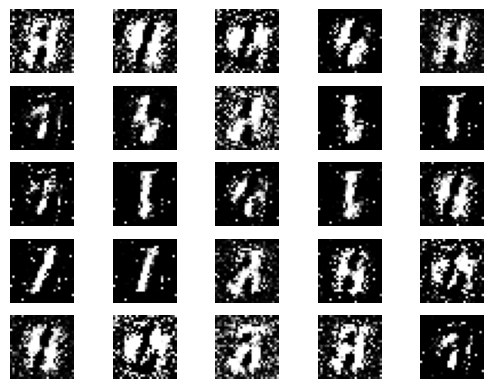

[326/400][0/16] 	Loss_D: 0.1719	Loss_G: -0.0388	D(x): 0.9226	D(G(z)): 0.0085
[327/400][0/16] 	Loss_D: 0.0661	Loss_G: -0.0169	D(x): 0.9829	D(G(z)): 0.0436
[328/400][0/16] 	Loss_D: 0.2472	Loss_G: -0.0006	D(x): 0.9884	D(G(z)): 0.1958
[329/400][0/16] 	Loss_D: 0.3721	Loss_G: -0.0224	D(x): 0.8576	D(G(z)): 0.0440
[330/400][0/16] 	Loss_D: 0.1100	Loss_G: -0.0338	D(x): 0.9684	D(G(z)): 0.0626
[331/400][0/16] 	Loss_D: 0.1853	Loss_G: -0.0410	D(x): 0.9490	D(G(z)): 0.1058
[332/400][0/16] 	Loss_D: 0.2006	Loss_G: -0.0744	D(x): 0.8954	D(G(z)): 0.0185
[333/400][0/16] 	Loss_D: 0.0553	Loss_G: -0.0149	D(x): 0.9812	D(G(z)): 0.0317
[334/400][0/16] 	Loss_D: 0.2351	Loss_G: -0.0009	D(x): 0.9933	D(G(z)): 0.1892
[335/400][0/16] 	Loss_D: 0.1103	Loss_G: -0.0065	D(x): 0.9412	D(G(z)): 0.0090
[336/400][0/16] 	Loss_D: 0.1106	Loss_G: -0.0296	D(x): 0.9656	D(G(z)): 0.0483
[337/400][0/16] 	Loss_D: 0.1237	Loss_G: -0.0071	D(x): 0.9813	D(G(z)): 0.0895
[338/400][0/16] 	Loss_D: 0.1282	Loss_G: -0.0020	D(x): 0.9405	D(G(z)): 0.0069

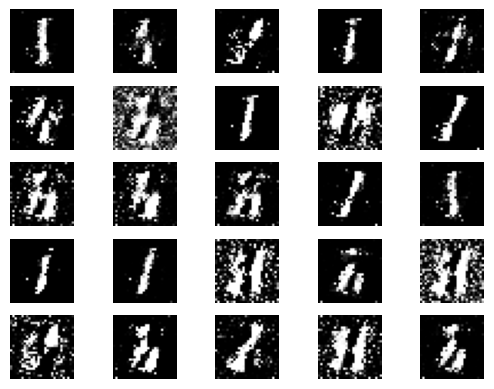

[351/400][0/16] 	Loss_D: 0.7360	Loss_G: -0.0123	D(x): 0.8718	D(G(z)): 0.0001
[352/400][0/16] 	Loss_D: 0.0910	Loss_G: -0.0228	D(x): 0.9815	D(G(z)): 0.0488
[353/400][0/16] 	Loss_D: 0.2763	Loss_G: -0.0036	D(x): 0.9665	D(G(z)): 0.1830
[354/400][0/16] 	Loss_D: 0.5393	Loss_G: -0.1340	D(x): 0.8254	D(G(z)): 0.0013
[355/400][0/16] 	Loss_D: 0.0810	Loss_G: -0.0280	D(x): 0.9750	D(G(z)): 0.0452
[356/400][0/16] 	Loss_D: 0.1247	Loss_G: -0.0342	D(x): 0.9372	D(G(z)): 0.0113
[357/400][0/16] 	Loss_D: 0.0533	Loss_G: -0.0154	D(x): 0.9903	D(G(z)): 0.0410
[358/400][0/16] 	Loss_D: 0.2251	Loss_G: -0.0007	D(x): 0.9722	D(G(z)): 0.1648
[359/400][0/16] 	Loss_D: 0.5933	Loss_G: -0.0000	D(x): 0.9879	D(G(z)): 0.3554
[360/400][0/16] 	Loss_D: 0.3033	Loss_G: -0.0494	D(x): 0.8678	D(G(z)): 0.0299
[361/400][0/16] 	Loss_D: 0.2752	Loss_G: -0.0600	D(x): 0.8775	D(G(z)): 0.0209
[362/400][0/16] 	Loss_D: 0.1572	Loss_G: -0.0469	D(x): 0.9436	D(G(z)): 0.0200
[363/400][0/16] 	Loss_D: 0.0440	Loss_G: -0.0132	D(x): 0.9844	D(G(z)): 0.0256

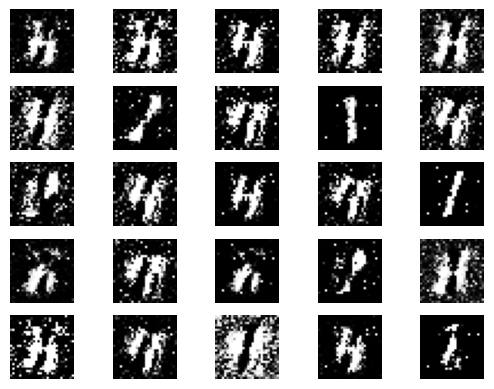

[376/400][0/16] 	Loss_D: 1.7082	Loss_G: -0.0014	D(x): 0.6528	D(G(z)): 0.0000
[377/400][0/16] 	Loss_D: 0.1580	Loss_G: -0.0198	D(x): 0.9471	D(G(z)): 0.0332
[378/400][0/16] 	Loss_D: 0.2325	Loss_G: -0.0577	D(x): 0.8957	D(G(z)): 0.0301
[379/400][0/16] 	Loss_D: 0.1166	Loss_G: -0.0198	D(x): 0.9709	D(G(z)): 0.0632
[380/400][0/16] 	Loss_D: 0.0725	Loss_G: -0.0127	D(x): 0.9527	D(G(z)): 0.0086
[381/400][0/16] 	Loss_D: 0.0224	Loss_G: -0.0084	D(x): 0.9911	D(G(z)): 0.0123
[382/400][0/16] 	Loss_D: 0.0234	Loss_G: -0.0070	D(x): 0.9964	D(G(z)): 0.0193
[383/400][0/16] 	Loss_D: 0.0877	Loss_G: -0.0018	D(x): 0.9939	D(G(z)): 0.0759
[384/400][0/16] 	Loss_D: 0.0345	Loss_G: -0.0077	D(x): 0.9873	D(G(z)): 0.0165
[385/400][0/16] 	Loss_D: 0.0487	Loss_G: -0.0135	D(x): 0.9782	D(G(z)): 0.0215
[386/400][0/16] 	Loss_D: 0.0892	Loss_G: -0.0091	D(x): 0.9871	D(G(z)): 0.0644
[387/400][0/16] 	Loss_D: 0.1395	Loss_G: -0.0013	D(x): 0.9537	D(G(z)): 0.0017
[388/400][0/16] 	Loss_D: 0.0912	Loss_G: -0.0198	D(x): 0.9641	D(G(z)): 0.0223

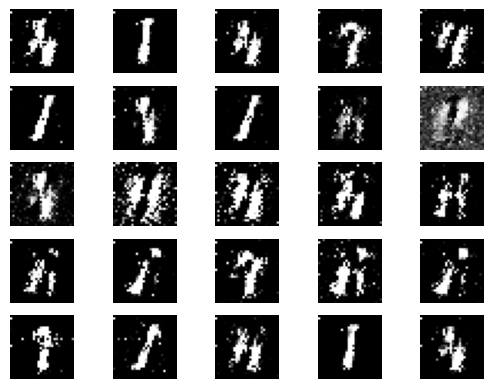

In [88]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0,n_iters_inner):
        
      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels 
      true_imgs = data[0] # FILL IN HERE
      true_labels = torch.ones((len(data[1]))) # FILL IN HERE
      # put true data through discriminator
      d_output_true = disc_model(true_imgs) # FILL IN HERE
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true.flatten(), true_labels) # FILL IN HERE
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise = torch.rand(batch_size, z_dim) # FILL IN HERE
      # Generate batch of fake images
      fake_imgs = gen_model(z_latent_noise) # FILL IN HERE
      fake_labels = torch.zeros(len(fake_imgs)) # FILL IN HERE
      # put fake data through discriminator
      disc_output_fake = disc_model(fake_imgs.detach()) # FILL IN HERE
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake.flatten(), fake_labels) # FILL IN HERE
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward()
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake = disc_model(fake_imgs) # FILL IN HERE
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake) # FILL IN HERE
    # backpropagation for generator
    g_loss.backward()
    #D_G_z2 = output.mean().item()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())

  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

# end samples
sample_images(gen_model,z_dim, rand_seed=30)


## 6/ Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points. 

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here. 

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

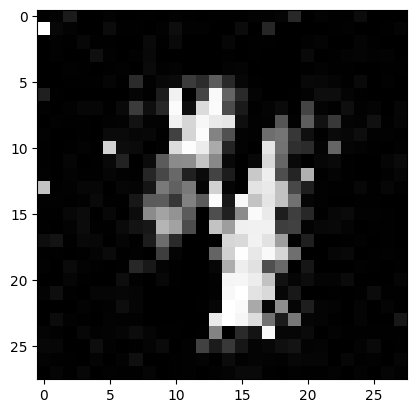

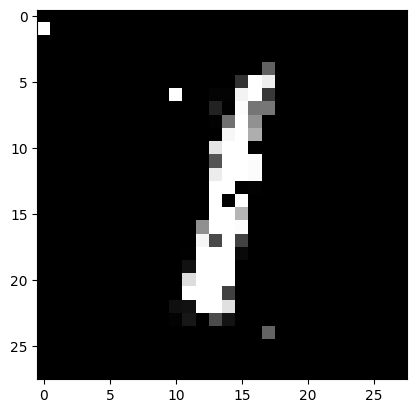

In [115]:
# first image
random_seed = 100 # change this seed to find the best image
torch.manual_seed(random_seed)
z_0 = torch.zeros(z_dim) # FILL IN HERE
x_0 = gen_model(z_0) # FILL IN HERE

random_seed = 20 # change this seed to find the best image
torch.manual_seed(random_seed)
z_1 = torch.ones(z_dim)  # FILL IN HERE
x_1 = gen_model(z_1) # FILL IN HERE

# display images
plt.imshow(x_0[0,0,:,:].detach().numpy(), cmap='gray')
plt.show()
plt.imshow(x_1[0,0,:,:].detach().numpy(), cmap='gray')
plt.show()

# FILL IN HERE

Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

In [131]:
n_interpolation = 20

z_inter = torch.zeros(n_interpolation, z_dim)

# FILL IN HERE
for i in range(n_interpolation):
  t = i/n_interpolation
  z_inter[i] = ( t * z_0 + (1-t) * z_1)

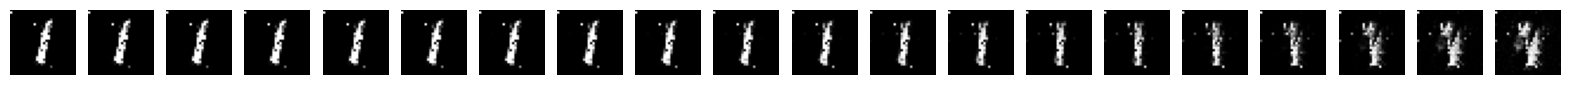

In [132]:
# display results

fig, axs = plt.subplots(1, n_interpolation,figsize=(20,20))
for i in range(n_interpolation):
  #black and white images
  axs[i].imshow( gen_model(z_inter[i]).view(28,28).detach().numpy() , cmap='gray')  # FILL IN HERE
  axs[i].axis('off')
plt.show()

What do you think of the quality of the output images ?

__Answer__

The first output image is already not very clear (not exactly mode collapse but almost). The inbetween images from the 1 to the 4 (interpolated) are mostly closer to the 1, but the last interpolations are not recognisable. 

## 7/ Evaluation of navigation

Now, we are going to evaluate this navigation. We will investigate two properties:

- 1/ We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;
- 2/ We are going to see whether the confidence of a classification network in different regions varies much. In other words, when we navigate in the latent space, do we go into zones which do not correspond to any number (according to the classification network) ? 

For this, we will first need a classification network. Take the code from the last lab work on variational autoencoders, and extract the section where we trained a classifier on mnist. Here is the architecture we used:

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

In [133]:
# define mnist classifier model, loss function, optimiser and the function 'get_accuracy'

# FILL IN HERE

learning_rate = 0.01
n_epochs = 20
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

mnist_classification_model = nn.Sequential(
    nn.Conv2d(in_channels=n_h_0, out_channels=n_h_1, kernel_size=kernel_size, stride=(2,2), padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=n_h_1, out_channels=n_h_2, kernel_size=kernel_size, stride=(2,2), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=pool_size, stride=(2,2)),
    nn.Flatten(),
    nn.Linear(in_features=288, out_features=10)
) # FILL IN CODE HERE

criterion = nn.CrossEntropyLoss() # FILL IN CODE HERE
optimizer = torch.optim.Adam(mnist_classification_model.parameters(), lr=learning_rate)

In [134]:
def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

In [135]:
# training the classifier

# FILL IN HERE
train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):

    # set the gradients back to 0
    optimizer.zero_grad()
    predict=mnist_classification_model(imgs)
    # apply loss function
    loss=criterion(predict,labels)
    acc = get_accuracy(torch.argmax(predict,dim=1),labels)
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch,train_loss/imgs.shape[0],acc))

Epoch:0 Train Loss:0.0226 Accuracy:0.7000
Epoch:1 Train Loss:0.0178 Accuracy:0.8750
Epoch:2 Train Loss:0.0056 Accuracy:0.9250
Epoch:3 Train Loss:0.0042 Accuracy:0.9750
Epoch:4 Train Loss:0.0048 Accuracy:0.9000
Epoch:5 Train Loss:0.0010 Accuracy:1.0000
Epoch:6 Train Loss:0.0010 Accuracy:1.0000
Epoch:7 Train Loss:0.0033 Accuracy:0.9750
Epoch:8 Train Loss:0.0001 Accuracy:1.0000
Epoch:9 Train Loss:0.0006 Accuracy:1.0000
Epoch:10 Train Loss:0.0016 Accuracy:0.9750
Epoch:11 Train Loss:0.0002 Accuracy:1.0000
Epoch:12 Train Loss:0.0010 Accuracy:0.9750
Epoch:13 Train Loss:0.0005 Accuracy:1.0000
Epoch:14 Train Loss:0.0001 Accuracy:1.0000
Epoch:15 Train Loss:0.0001 Accuracy:1.0000
Epoch:16 Train Loss:0.0002 Accuracy:1.0000
Epoch:17 Train Loss:0.0001 Accuracy:1.0000
Epoch:18 Train Loss:0.0000 Accuracy:1.0000
Epoch:19 Train Loss:0.0000 Accuracy:1.0000


### 7.1/ Evaluation of navigation part 1

Now, create a function which returns the classification returned by this network on mnist images. Remember, the classification model above returns the values __before__ the softmax is applied, and here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).


In [147]:
def predict_mnist_class(imgs_in,classification_model):
  output_classes = nn.Softmax()(classification_model(imgs_in)).argmax(dim=1) # FILL IN HERE
  return(output_classes)

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

In [149]:
z_classes = predict_mnist_class(gen_model(z_inter).detach() , mnist_classification_model) # FILL IN HERE
print(z_classes)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4])


<ipython-input-147-3f8ef5b94176>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_classes = nn.Softmax()(classification_model(imgs_in)).argmax(dim=1) # FILL IN HERE


__Answer__

It fits what I answered previously. The latent space navigation does not traverse regions with other classes. 

### 7.2/ Evaluation of navigation part 2

Even though the network may predict coherent image classes during the navigation, it may predict these classes with different confidences. Ideally, we would like the latent space to contain codes which produce images of constant quality. Therefore, as mentioned above, we want to check these prediction confidences during navigation on our GAN.

Carry this out now. First of all, define a function which, instead of funding the output *classes* of the interpolations, find the *probability* of the most likely class (the same operation as in the lab on variational autoencoders).


In [151]:
def predict_mnist_confidence(imgs_in,classification_model):
  output_classes =  nn.Softmax()(classification_model(imgs_in)).max(dim=1) # FILL IN HERE
  return(output_classes)

Using this function, carry out the second evaluation on the images generated by interpolated latent codes.

In [152]:
z_confidence = predict_mnist_confidence(gen_model(z_inter).detach() , mnist_classification_model) #FILL IN HERE
print(z_confidence)

torch.return_types.max(
values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 0.9965, 0.7736,
        0.9555, 0.8834], grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4]))


<ipython-input-151-532c11361e3a>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_classes =  nn.Softmax()(classification_model(imgs_in)).max(dim=1) # FILL IN HERE


Does the confidence change greatly during interpolation ? Does the navigation go through zones where the classification is not confident ? Why do you think this is ? (think about the form/shape of the latent space).

__Answer__

It mostly stays constant, but around the change of class, we have a lower confidence, because the digit is a mix between the two form/shape. 

# __Optional__ : Training on CIFAR

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [ ]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

Now, we can redefine the hyper-parameters of the model (change if you wish)

In [ ]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 

In [ ]:
# GAN implementation

# FILL IN HERE

Now, carry out the training (use code above)

In [ ]:
# training code

# FILL IN HERE